In [120]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from umap import UMAP

logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [152]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/isOld_ukb_without_residualization.csv"
label_before = "Age"
label = "isOld"

In [162]:
participants = pd.read_csv(participants_file, index_col=0)
print(len(participants))
# participants = participants[[label]].dropna()

# On prend les 10% les plus jeunes et les 10% les plus vieux
# des sujets effectivement acquis
# Ils n'ont pas la même distribution en âge par rapport à tous les sujets
model_path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0/ScCal-SLi_left/09-28-12_0"
embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
participants = pd.read_csv(participants_file, index_col=0)
participants = participants[[label_before]].dropna()
target = participants[[label_before]].merge(embeddings, left_index=True, right_index=True)
q_10 = target[label_before].quantile(q=0.1)
q_90 = target[label_before].quantile(q=0.9)
target[label] = target.apply(lambda x: 0 if x[label_before] < q_10 else 1 if x[label_before] > q_90 else np.nan, axis=1)
target[label] = target[label].astype('Int64')
participants = target[[label]].dropna()

38019


In [123]:
# participants[:] = participants.sample(frac=1).values

array([[<Axes: title={'center': 'isOld'}>]], dtype=object)

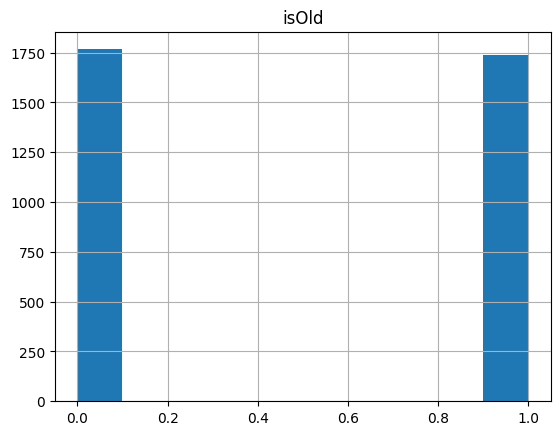

In [124]:
participants.hist()

In [125]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [126]:
model_paths = get_model_paths(path_champollion)

In [127]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [128]:
# df = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
# pca = PCA(n_components=1)
# df2 = pd.DataFrame(pca.fit_transform(df))
# df2.index = df.index
# df2


In [129]:
def compute(model_path, random_state):
    global embeddings
    global participants
    global results, X, Y, df2
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
        
    # Classifies
    X = merged.drop([label], axis=1)
    Y = merged[[label]]

    # Standard scaler
    scaler = StandardScaler()
    X[X.columns] = scaler.fit_transform(X)
    df2 = X.copy()

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue

    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [130]:
participants.dtypes

isOld    Int64
dtype: object

In [131]:
result = []
for random_state in range(1):

    # Computes AUC
    for model_path in model_paths:
        result.append(compute(model_path, random_state))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
2.261458714653678
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
2.024222309202607
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
4.048604595030806
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
6.756385276546882
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
9.397739482929275
Treating S.C.-sylv._right: SC-sylv_right/11-43-38_3 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/11-43-38_3
2

In [132]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  isOld   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     4.439
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           2.84e-90
Time:                        09:49:52   Log-Likelihood:                -2016.6
No. Observations:                3503   AIC:                             4547.
Df Residuals:                    3246   BIC:                             6131.
Df Model:                         256                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4956      0.008     65.615      0.000       0.481       0.510
dim1          -0.7894      0.723     -1.092      0.275      -2.207       0.628
dim2          -0.4038      1.409     -0.287      0.774      -3.166       2.359
dim3           0.5891      0.438      1.346      0.178      -0.269       1.447
dim4          -0.5173      0.747     -0.692      0.489      -1.983       0.948
dim5          -3.9727      1.206     -3.295      0.001      -6.337      -1.609
dim6          -3.4254      1.746     -1.962      0.050      -6.848      -0.003
dim7           1.2383      1.185      1.045      0.296      -1.085       3.562
dim8          -0.1452      1.186     -0.122      0.903      -2.471       2.181
dim9          -4.9988      1.537     -3.252      0.001      -8.013      -1.985
dim10         -2.0018      0.909     -2.202      0.028      -3.784      -0.219
dim11          0.2331      0.777      0.300      0.764      -1.290       1.757
dim12         -1.0938      1.095     -0.999      0.318      -3.240       1.053
dim13         -0.1432      1.044     -0.137      0.891      -2.190       1.904
dim14         -3.0581      1.171     -2.613      0.009      -5.353      -0.763
dim15         -0.9821      1.220     -0.805      0.421      -3.374       1.410
dim16         -2.5828      1.194     -2.162      0.031      -4.925      -0.241
dim17          0.8947      1.470      0.609      0.543      -1.988       3.777
dim18         -0.2025      1.156     -0.175      0.861      -2.469       2.064
dim19          3.9830      1.380      2.887      0.004       1.278       6.688
dim20         -0.6620      1.166     -0.568      0.570      -2.949       1.625
dim21         -0.2524      1.001     -0.252      0.801      -2.215       1.710
dim22          2.1733      1.193      1.822      0.069      -0.166       4.512
dim23          0.1841      1.148      0.160      0.873      -2.067       2.435
dim24         -0.1539      0.502     -0.307      0.759      -1.138       0.830
dim25         -2.6040      1.171     -2.224      0.026      -4.900      -0.308
dim26          2.1324      0.850      2.510      0.012       0.467       3.798
dim27         -0.2757      1.251     -0.220      0.826      -2.729       2.177
dim28          1.6269      1.352      1.203      0.229      -1.024       4.278
dim29         -2.3024      1.101     -2.091      0.037      -4.461      -0.144
dim30          1.3647      1.313      1.039      0.299      -1.210       3.940
dim31          0.8452      0.622      1.359      0.174      -0.374       2.064
dim32         -0.7970      1.132     -0.704      0.481      -3.016       1.422
dim33         -3.2344      1.337     -2.420      0.016      -5.855      -0.614
dim34         -1.5281      1.530     -0.999      0.318      -4.527       1.471
dim35         -0.2102      1.743     -0.121      0.904      -3.627       3.207
di

In [133]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [134]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,2.261459,6.036118e-24,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,2.024222,7.467585e-18,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,4.048605,8.052122e-78,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,6.756385,1.187025e-163,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,9.397739,2.566610e-242,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,3.510187,8.341638e-61,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
73,S.T.s._left,5.054048,5.665475e-110,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
74,F.C.M.post.-S.p.C._right,3.711947,3.817508e-67,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
75,ORBITAL_right,4.204654,8.507100e-83,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [135]:
df['side'] = df['region'].str.split('_').str[-1]

In [136]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,S.C.-sylv._left,2.261459,6.036118e-24,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,2.024222,7.467585e-18,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,4.048605,8.052122e-78,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,6.756385,1.187025e-163,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,9.397739,2.566610e-242,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
72,S.F.inter.-S.F.sup._right,3.510187,8.341638e-61,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
73,S.T.s._left,5.054048,5.665475e-110,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
74,F.C.M.post.-S.p.C._right,3.711947,3.817508e-67,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
75,ORBITAL_right,4.204654,8.507100e-83,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [137]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.05, color='black', linestyle='-')
    ax.barh(res[region_name], res[f2_value], fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [138]:
0.05/56

0.0008928571428571429

In [139]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
19,F.C.L.p.-subsc.-F.C.L.a.-INSULA._right,10.832402,2.448306e-282,19-49-20_193,FCLp-subsc-FCLa-INSULA_right/19-49-20_193,/neurospin/dico/data/deep_folding/current/mode...,right
33,F.P.O.-S.Cu.-Sc.Cal._left,10.777815,7.533389e-281,20-03-37_0,FPO-SCu-ScCal_left/20-03-37_0,/neurospin/dico/data/deep_folding/current/mode...,left
31,Sc.Cal.-S.Li._left,10.673619,5.309224e-278,09-28-12_0,ScCal-SLi_left/09-28-12_0,/neurospin/dico/data/deep_folding/current/mode...,left
29,fronto-parietal_medial_face._left,10.567428,4.343113e-275,13-07-50_190,fronto-parietal_medial_face_left/13-07-50_190,/neurospin/dico/data/deep_folding/current/mode...,left
59,F.C.L.p.-subsc.-F.C.L.a.-INSULA._left,9.856395,2.557257e-255,18-59-14_0,FCLp-subsc-FCLa-INSULA_left/18-59-14_0,/neurospin/dico/data/deep_folding/current/mode...,left
...,...,...,...,...,...,...,...
0,S.C.-sylv._left,2.261459,6.036118e-24,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
34,OCCIPITAL_left,2.209613,1.416529e-22,18-05-00_0,OCCIPITAL_left/18-05-00_0,/neurospin/dico/data/deep_folding/current/mode...,left
45,S.Pe.C._left,2.066544,6.635489e-19,12-36-31_0,SPeC_left/12-36-31_0,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,2.024222,7.467585e-18,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left


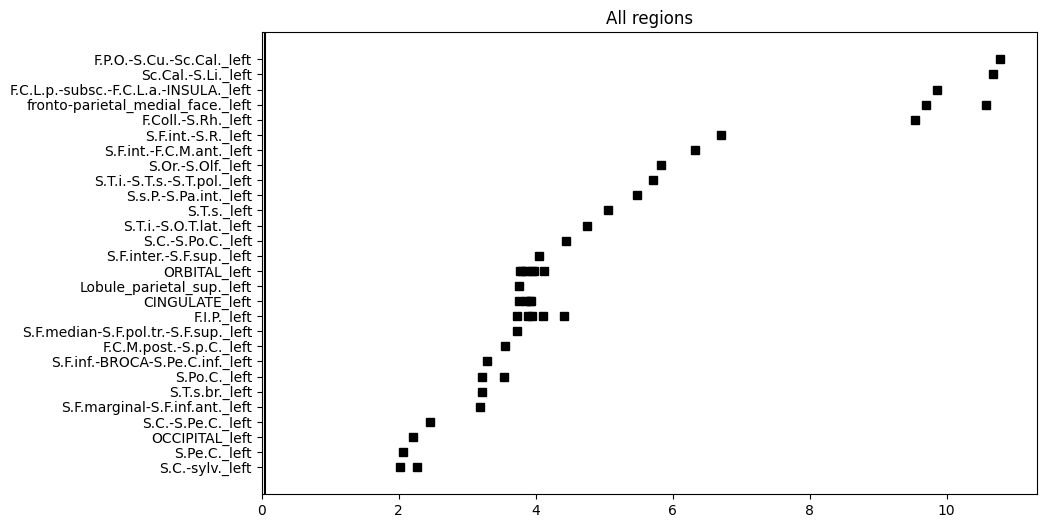

In [140]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

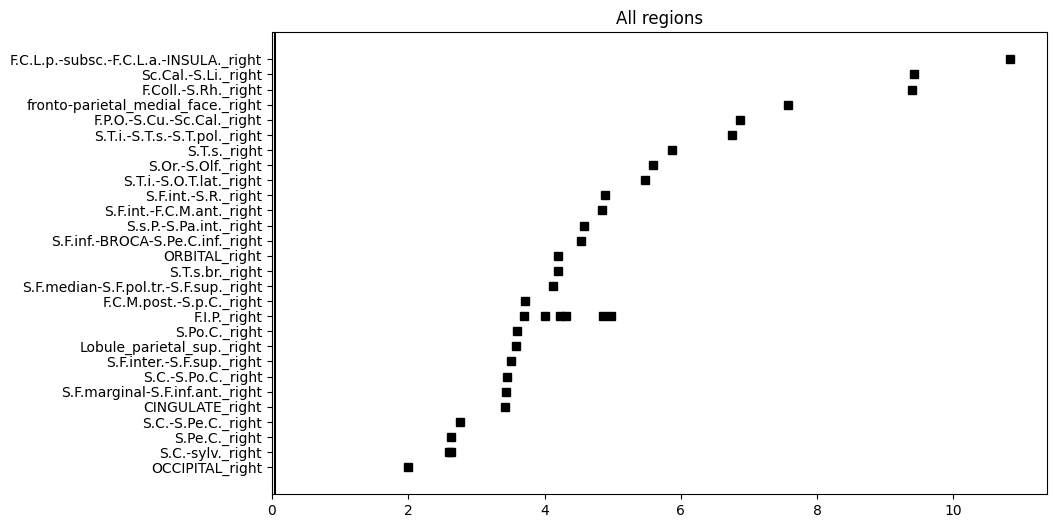

In [141]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [142]:
# df.to_csv(output_filename)

In [143]:
def compute_umap(df, n_neighbors=15, n_components=2):
    # apply umap
    reducer = UMAP(n_neighbors=n_neighbors, n_components=n_components)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

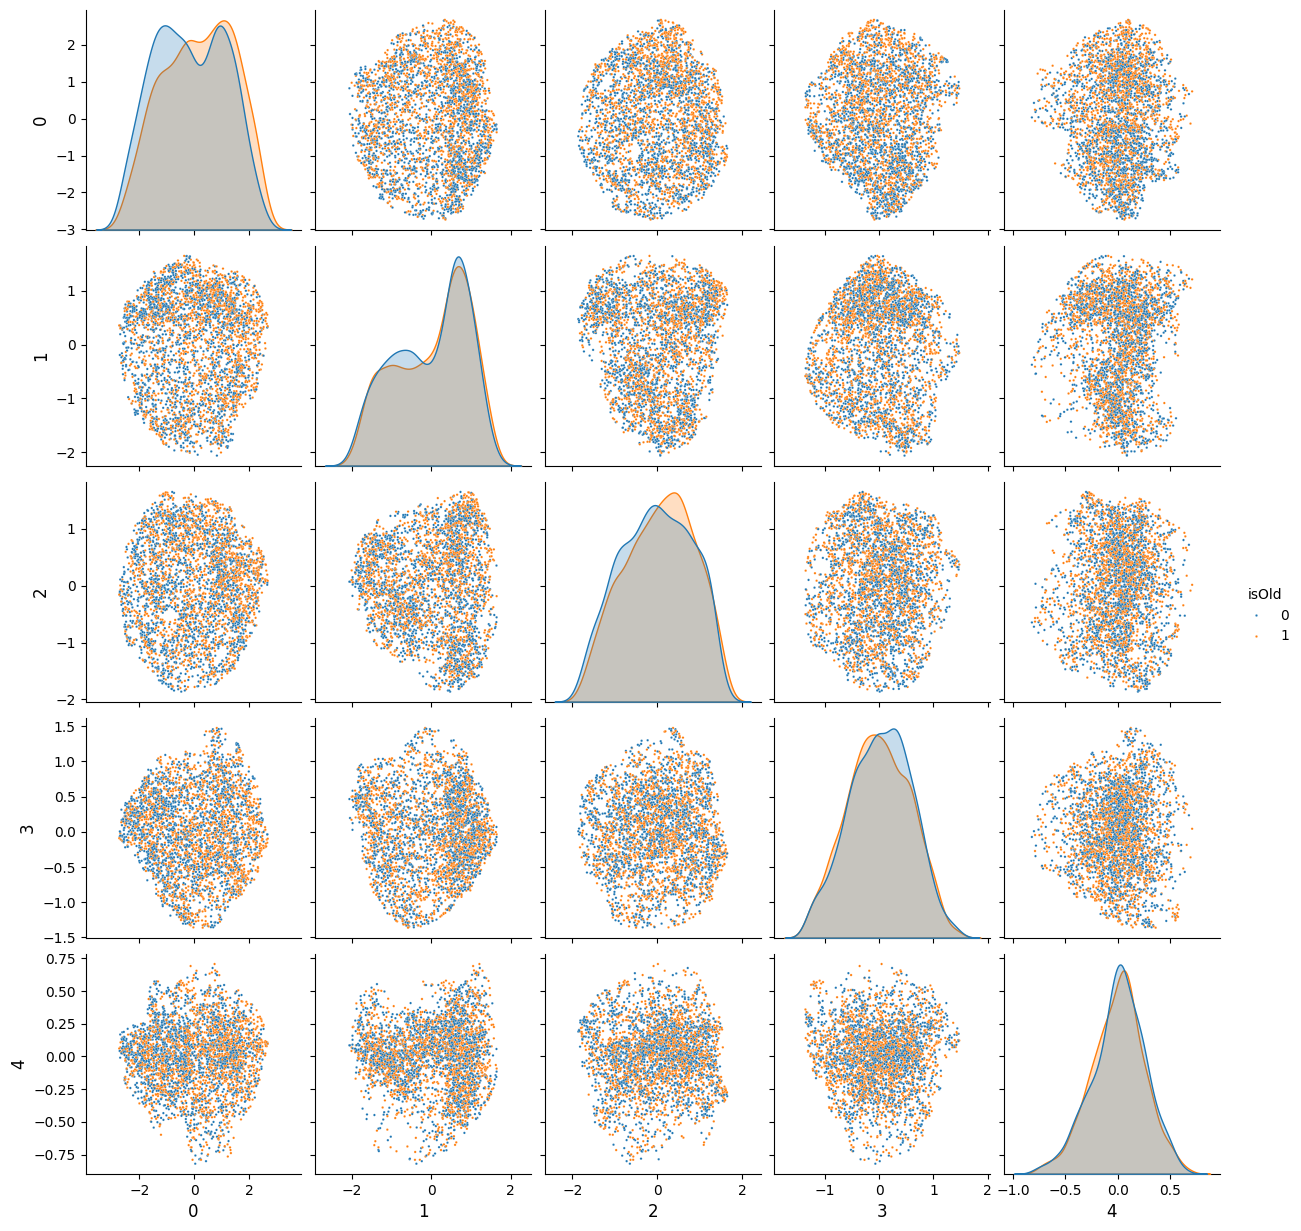

In [168]:
model_path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0/ScCal-SLi_left/09-28-12_0"
embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
# pca = PCA(n_components=5)
# b = pca.fit_transform(merged.iloc[:,1:])
b, _ = compute_umap(merged.iloc[:,1:], n_components = 20, n_neighbors=15)
pca = PCA(n_components=5)
b = pca.fit_transform(b)
df2 = pd.DataFrame(b)
df2.index = merged.index
df2 = df2.merge(merged[[label]], left_index=True, right_index=True)
sns.pairplot(df2, hue=label, plot_kws={"s": 3})

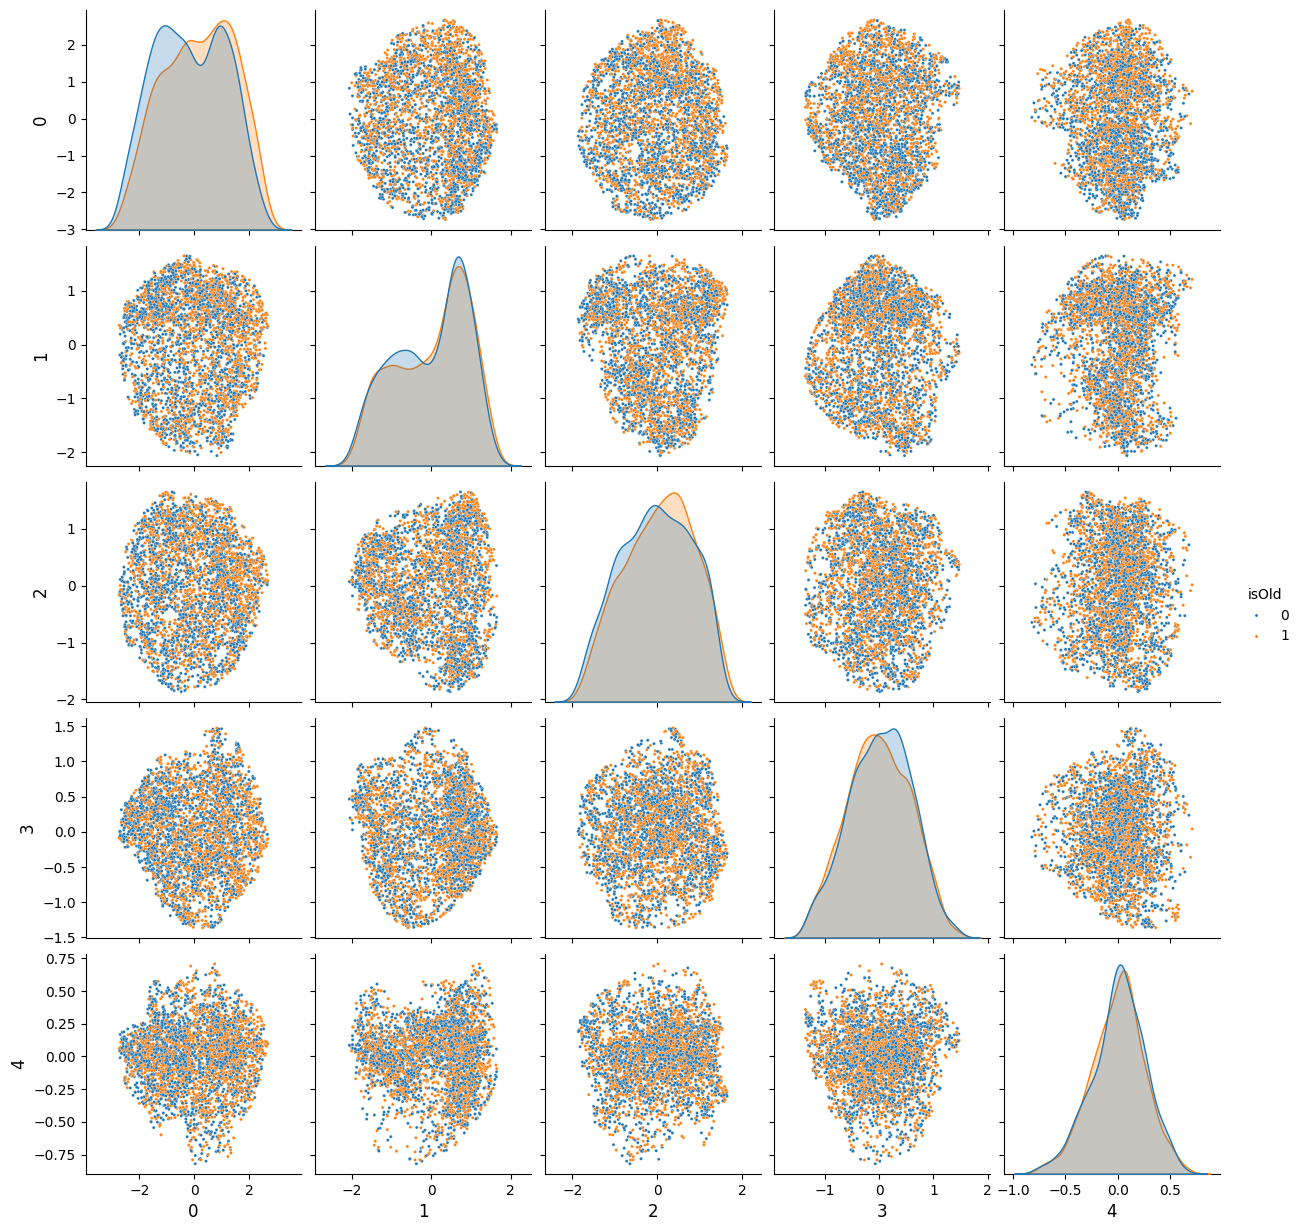

In [169]:
sns.pairplot(df2, hue=label, plot_kws={"s": 5})

In [163]:
model_path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0/ScCal-SLi_left/09-28-12_0"
embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)

# Classifies
X = merged.drop([label], axis=1)
Y = merged[[label]]

# Standard scaler
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)
df2 = X.copy()

# Makes OLS
df2 = sm.add_constant(df2)
model = sm.OLS(Y[label], df2)
results = model.fit()

p = results.params
p

const     0.495575
dim1      0.987775
dim2     -0.527130
dim3      2.155154
dim4     -0.648044
            ...   
dim252   -1.667628
dim253    2.695103
dim254   -1.131285
dim255    0.523026
dim256    0.120293
Length: 257, dtype: float64

<Axes: xlabel='isOld', ylabel='predicted'>

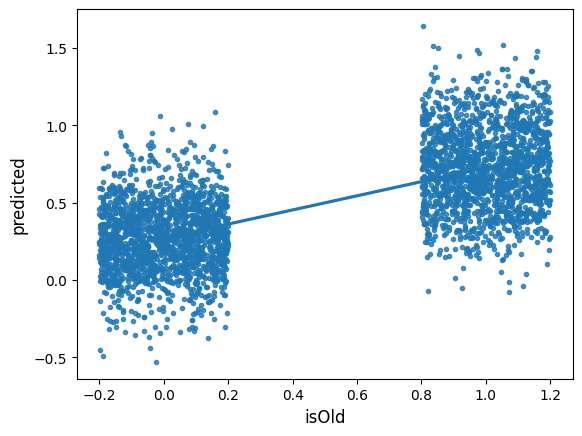

In [164]:
df3 = Y.copy()
df3["predicted"] = df2.dot(p)
sns.regplot(x="isOld", y="predicted", data=df3, x_jitter=0.2, marker='.')

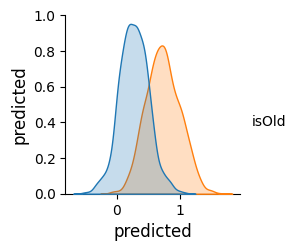

In [167]:
sns.pairplot(df3, hue="isOld")

In [165]:
len(merged[merged.isOld==1])

1736

In [166]:
participants

,isOld
sub-3798925,0
sub-1150302,1
sub-1538634,0
sub-2214448,1
sub-3465339,0
...,...
sub-1303921,0
sub-1796567,1
sub-2728481,0
sub-2780106,1


In [160]:
embeddings

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-44.764812,-7.561168,-27.046082,-33.584930,-13.237930,-10.817898,0.581217,28.097376,6.987557,-17.722223,...,-19.355621,22.879978,60.176323,34.403290,-50.994858,-61.453964,67.128075,-30.144411,-11.567401,-34.812770
sub-1000458,18.033236,-19.331535,4.588765,17.981405,20.067762,15.785610,-20.103287,27.118490,18.161518,15.049867,...,9.665567,13.187021,49.730540,-5.843871,34.320240,31.848700,25.309462,5.590658,1.110065,8.127332
sub-1000575,-9.152472,7.461522,-34.986843,56.177795,18.481247,28.050117,-22.019306,-20.583708,5.513316,20.022285,...,-5.060265,10.865500,38.559406,-16.595951,6.662376,-35.713223,20.241130,2.440343,-9.916403,5.771592
sub-1000606,-26.186844,-38.599330,-14.307706,35.718296,-26.845760,3.516212,24.741770,3.041305,-18.980959,4.707555,...,20.363668,19.099170,34.822926,-0.493881,-13.821614,21.030193,2.300773,-7.729381,-1.205893,23.747902
sub-1000963,-23.809263,-25.897652,5.828577,20.800860,2.034690,51.072227,6.297543,-33.402027,20.131933,-5.758612,...,2.499297,-20.839810,-1.513577,-3.883939,18.674840,20.531118,18.756912,-2.353150,5.136505,-8.554947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-6023469,-41.317240,-40.447784,-30.041615,-16.751925,-3.510754,32.433940,42.603153,-14.556619,38.658398,8.856137,...,7.294170,17.858904,14.641837,39.841465,-11.705192,-31.066736,-3.142765,0.310284,-3.552202,-20.834000
sub-6023808,-2.692974,-25.719662,-1.916609,10.499981,39.105064,20.467455,4.865832,-7.040365,13.695807,24.290066,...,-16.505777,17.831127,30.909016,0.408267,24.229828,-49.831936,66.218410,-0.754347,-19.414412,-29.457642
sub-6023847,-48.122066,-44.838470,29.136040,-12.767525,7.187038,-4.979211,17.509117,-7.293974,-2.724546,-24.633583,...,-17.365868,4.597022,-9.218680,1.169816,-12.880522,-35.096134,71.191170,-12.772809,-17.953390,-10.624347


In [161]:
embeddings.merge(participants, left_index=True, right_index=True)

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256,isOld
sub-1000021,-44.764812,-7.561168,-27.046082,-33.584930,-13.237930,-10.817898,0.581217,28.097376,6.987557,-17.722223,...,22.879978,60.176323,34.403290,-50.994858,-61.453964,67.128075,-30.144411,-11.567401,-34.812770,0.0
sub-1003286,-13.514448,-13.996918,-34.872630,5.499859,-12.832791,54.280075,-10.613273,-8.081469,60.596900,20.091648,...,-2.946175,45.186790,30.957740,-15.993033,-31.809425,-16.575562,-2.702735,28.308304,-22.020615,1.0
sub-1006097,-17.562447,-61.117447,13.088346,-17.026476,-3.495791,14.734079,17.887024,18.552132,17.704863,20.767036,...,30.830840,12.322971,18.985310,-43.558680,-47.493150,98.192880,-5.752061,7.951611,-12.071817,0.0
sub-1010381,-33.694233,-45.579865,-14.716499,29.400600,-31.322376,-2.684282,17.766926,-4.750330,-14.838368,-2.820195,...,15.380825,35.714207,17.456024,-26.363360,-3.173679,1.195982,-6.105568,-4.982765,36.957653,1.0
sub-1012329,-25.394615,-33.611572,-0.211567,7.224298,-8.294232,47.494495,10.728840,-46.960022,-0.780276,-11.456054,...,-27.039982,24.830280,29.620369,-11.558433,-10.915524,4.055311,17.301146,5.066193,3.494482,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-6014580,-21.720491,-74.475640,28.634739,7.883659,18.193092,13.424435,36.634490,-10.711473,-8.383260,-7.475402,...,22.337860,-11.963298,21.074303,29.297380,36.046726,31.700052,15.350940,-20.988255,6.946176,0.0
sub-6014976,-44.856354,-61.205933,16.595613,1.917783,-24.194870,18.498629,21.618204,-17.506730,14.637575,-24.702248,...,-12.413445,-25.006222,10.502536,-6.142838,1.082671,19.870056,-11.599527,-1.467037,6.471504,1.0
sub-6016144,-18.531360,-4.072125,-2.938314,17.511852,3.836970,3.445520,31.636660,-3.522931,-24.460314,-3.106105,...,7.434220,61.322372,9.090178,-1.998343,44.492504,13.417490,-0.717480,2.427970,16.138662,0.0
sub-6019097,-16.358530,29.397327,9.992284,54.738010,-10.008370,4.172127,15.028337,-25.299988,-13.504441,6.770020,...,-18.339020,79.993416,21.825413,7.313157,1.027133,-7.468558,2.364551,29.379702,29.468607,0.0
